# Anomoly Detection

### setup


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = ['blue' , 'green'])
plt.rcParams['figure.figsize'] = (20 , 10)
plt.rcParams['font.size'] = 15

In [3]:
# !gdown 10ZdMFvfhGeXAa8xR0J00kHIHp9y9m9uL --output ../data/wholesaledata.csv

In [4]:
df = pd.read_csv('../data/wholesaledata.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


<Axes: xlabel='Grocery', ylabel='Milk'>

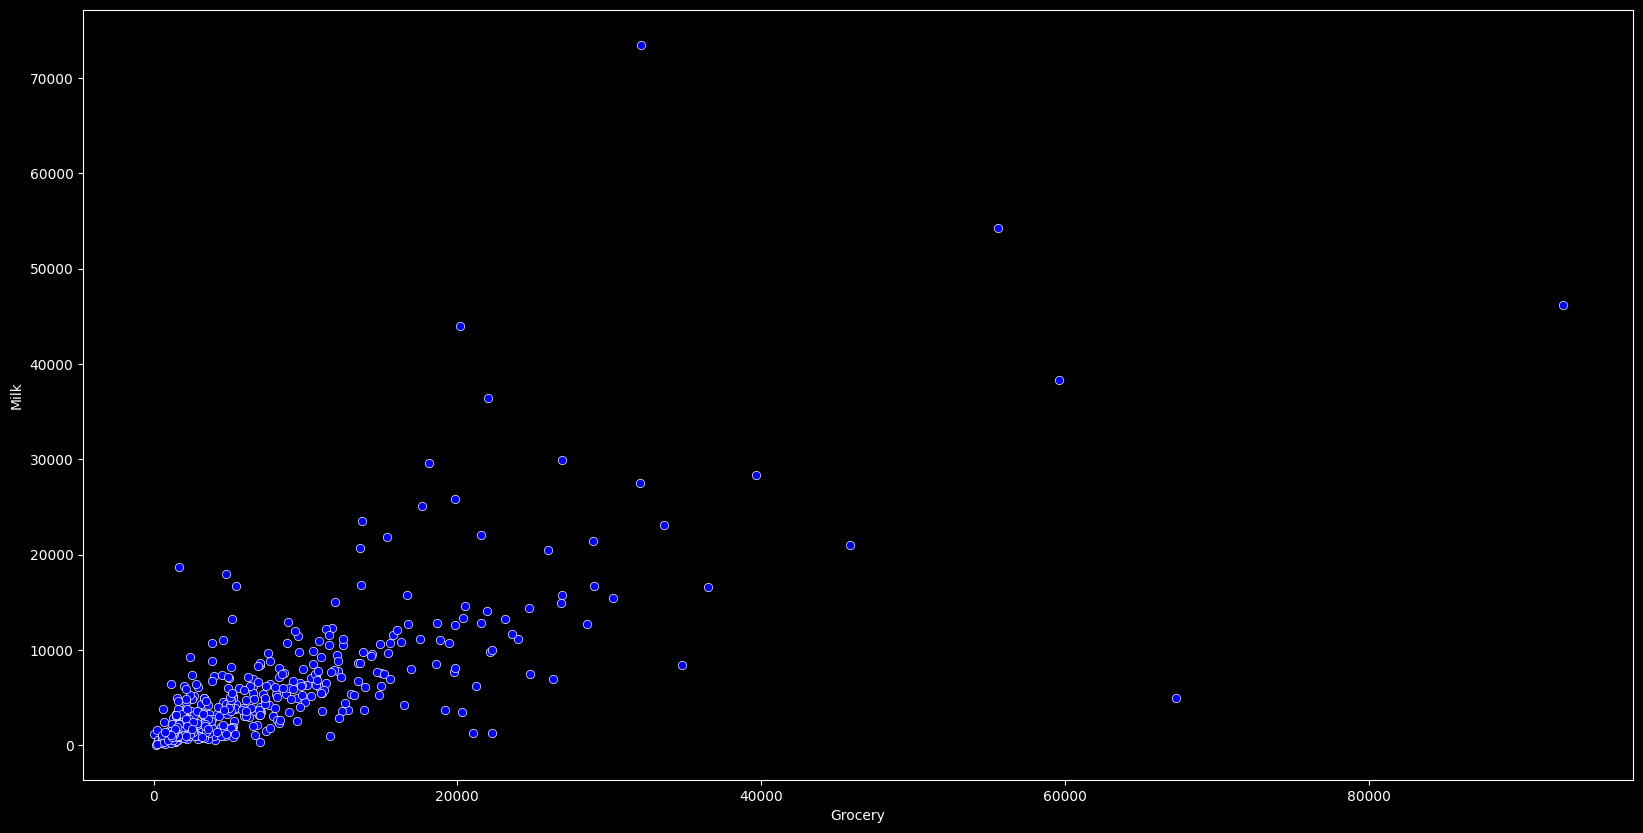

In [5]:
x = df['Grocery']
y = df['Milk']
sns.scatterplot(x = x ,  y = y)

In [6]:
# !gdown 1c6cjIULb3-fjyaVITdui_AFcKMz_lxlg --output ../data/anomolydata.csv

In [7]:
df = pd.read_csv('../data/anomolydata.csv')
df.head()

,Mileage,Price
0,54.282388,67.967708
1,17.331911,70.023637
2,36.548113,68.080455
3,42.567541,71.058755
4,5.608853,57.822432


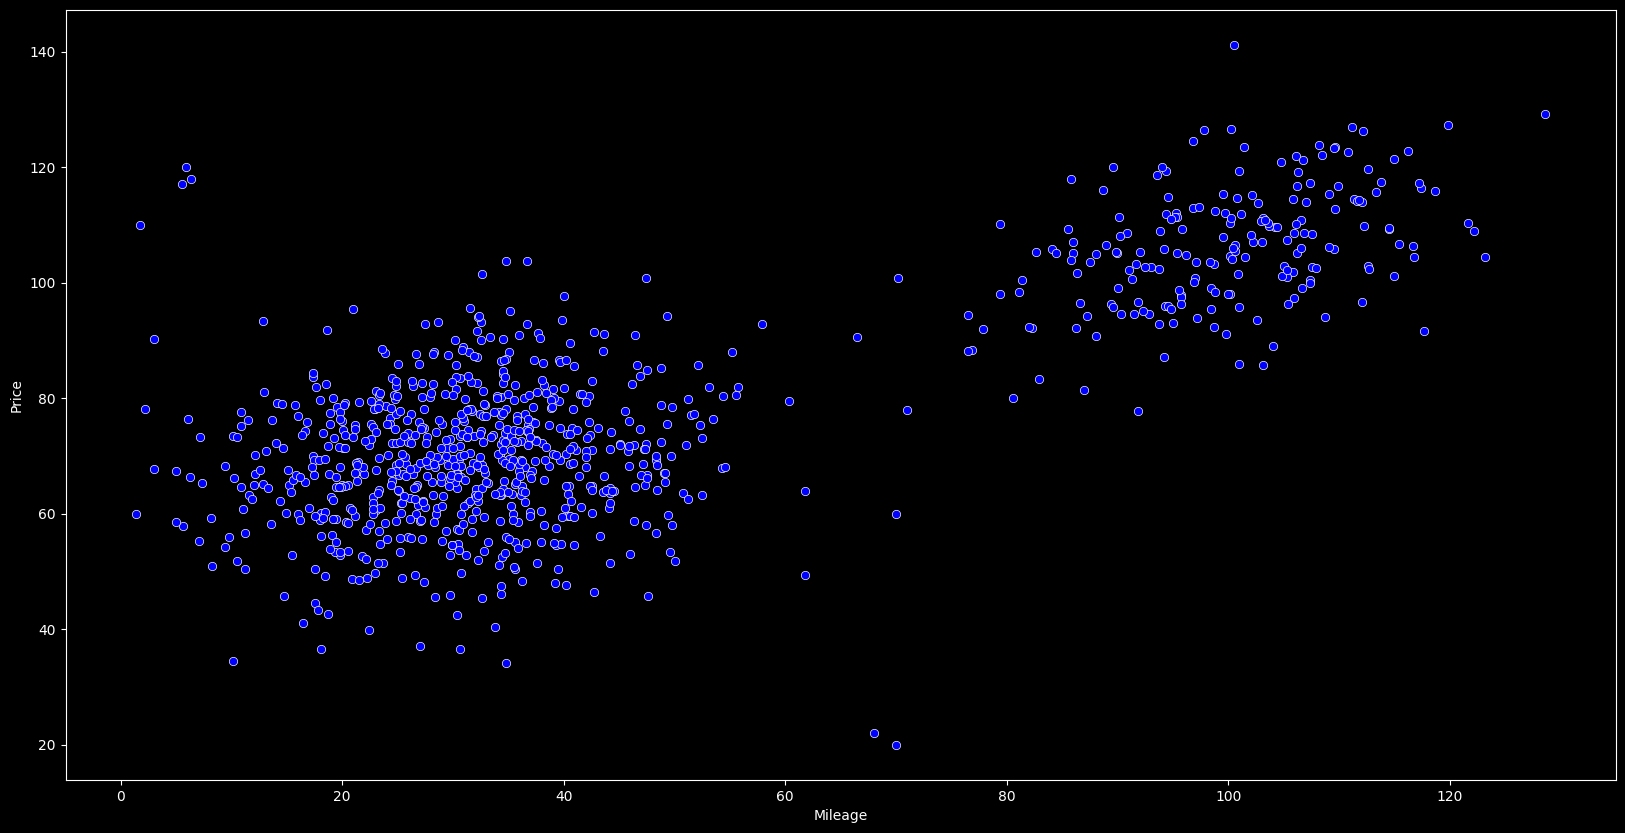

In [8]:
x = df['Mileage']
y = df['Price']
sns.scatterplot(x = x , y = y)
plt.show()

# Eliptic curve method:


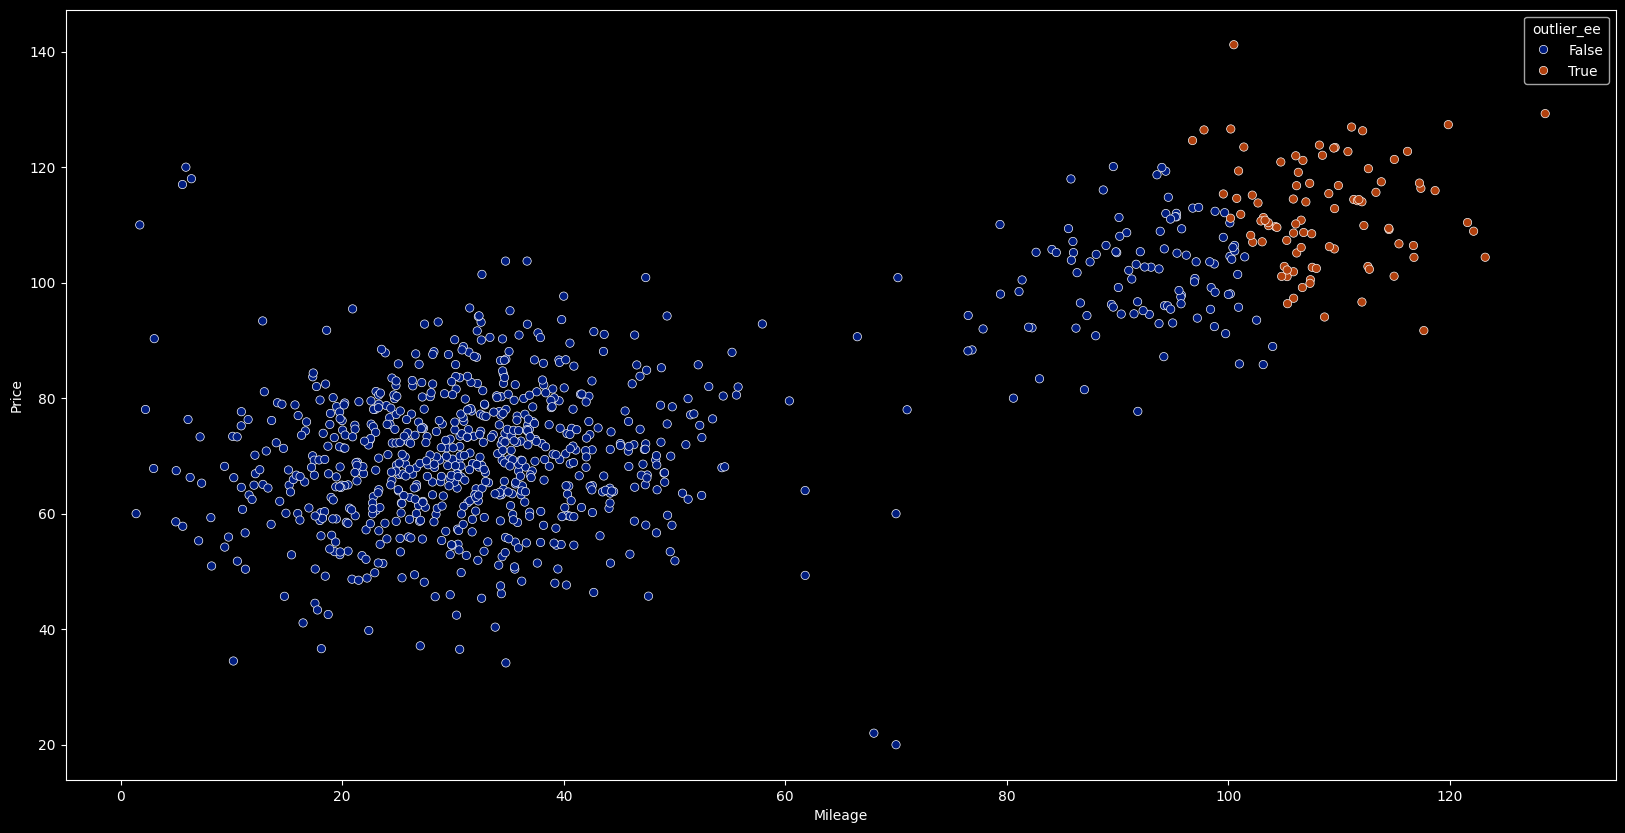

In [9]:
from sklearn.covariance import EllipticEnvelope

model = EllipticEnvelope(random_state= 0).fit(df)
df['outlier_ee'] = model.predict(df)
df['outlier_ee'] = df['outlier_ee'].apply(lambda x : False if x == 1 else True )
sns.scatterplot(df , x = 'Mileage' , y = 'Price' , hue = 'outlier_ee' , palette='dark')
plt.show()

# IQR method:


In [10]:
lq = np.percentile(x , 45)
uq = np.percentile(x , 75)
iqr = uq - lq
lq , uq , iqr

lb = max(0 , lq - (1.5 * iqr))
ub = uq + (1.5 * iqr)
lb , ub

(6.955735271780611, 75.60660447911988)

<Axes: xlabel='Mileage', ylabel='Price'>

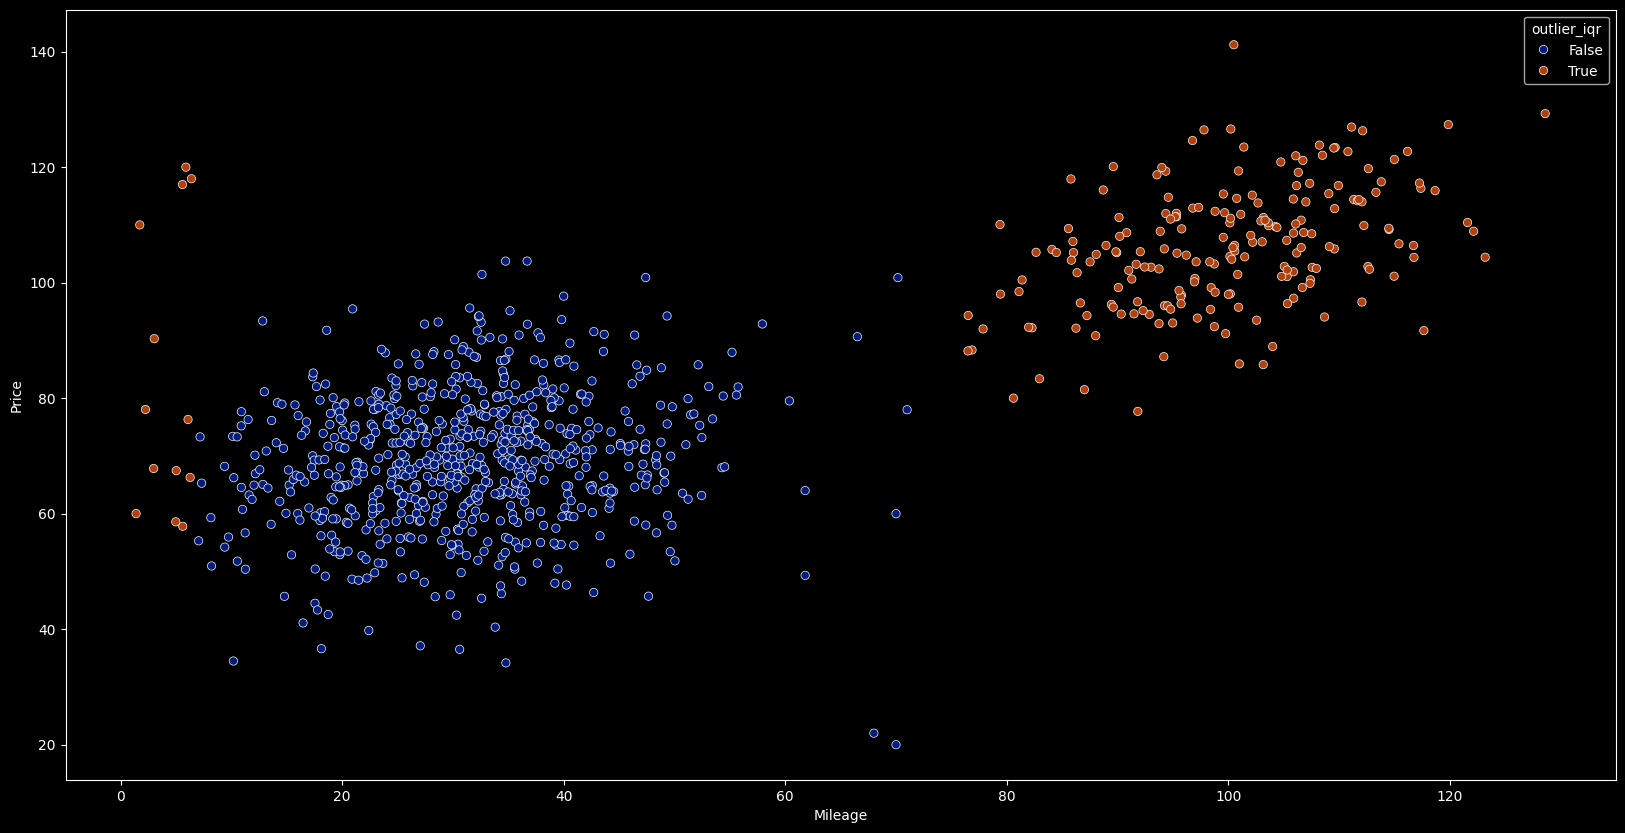

In [11]:
df['outlier_iqr'] = df['Mileage'].apply(lambda x : False if x >= lb and x <= ub else True)
sns.scatterplot(df , x= 'Mileage' , y = 'Price' , hue = 'outlier_iqr' , palette = 'dark')

# RANSAC:

- Random Sample Concensus


In [12]:
from sklearn.linear_model import RANSACRegressor , LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

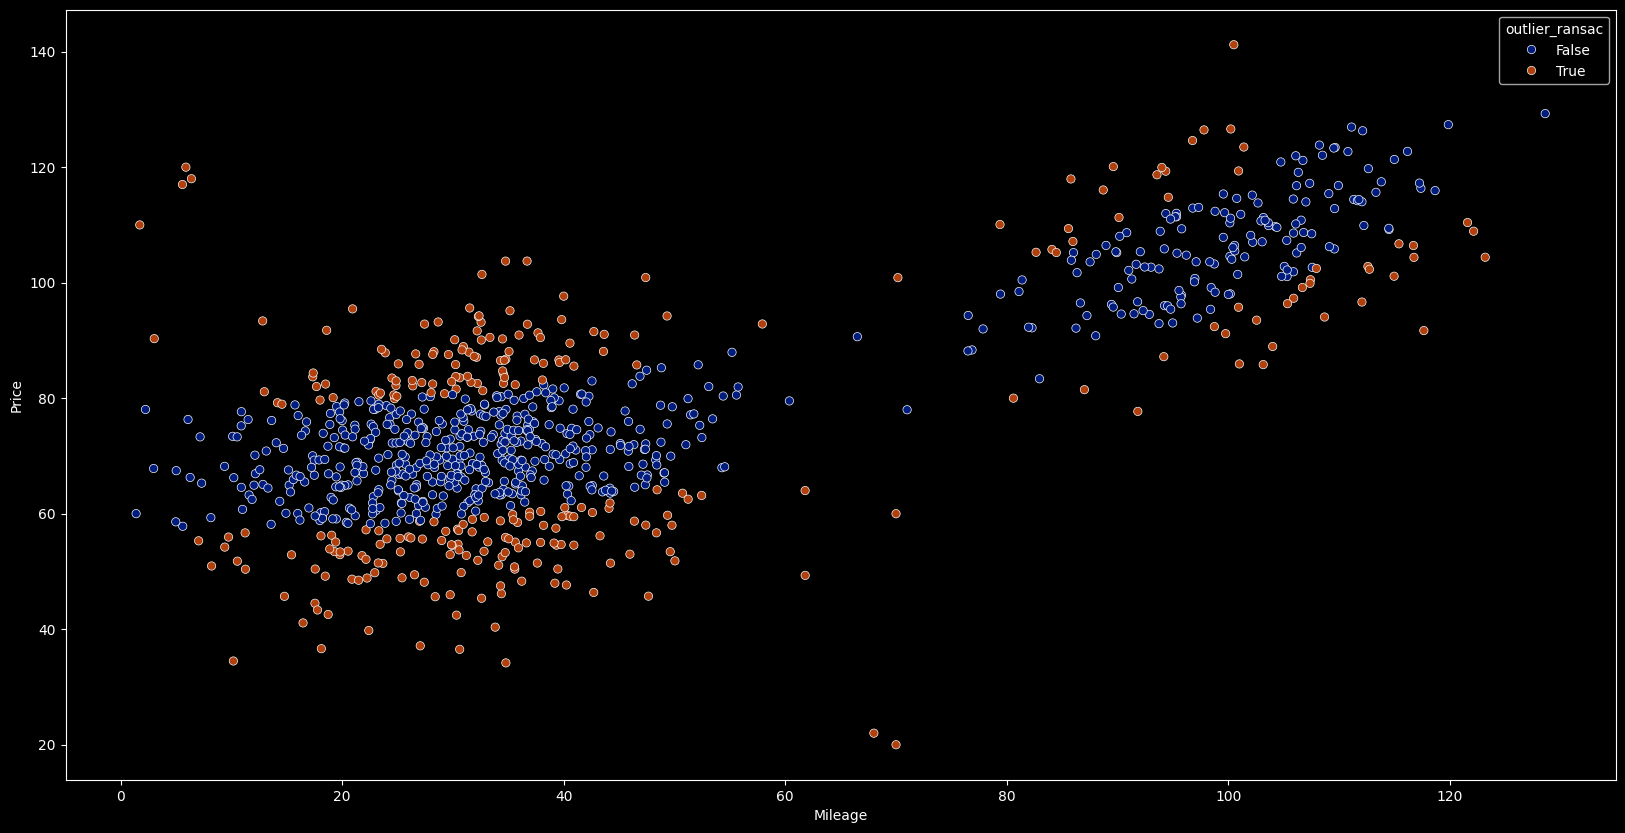

In [13]:
model = make_pipeline(PolynomialFeatures(degree = 2 , include_bias=False) , LinearRegression())

ransac = RANSACRegressor(estimator=model , min_samples=200 ,  max_trials=1000 , stop_probability= 0.9 , random_state= 0)
ransac.fit(x.to_numpy().reshape(-1 , 1) , y)
df['outlier_ransac'] = [not mask for mask in ransac.inlier_mask_]
sns.scatterplot(df , x = 'Mileage' , y = 'Price' , hue = 'outlier_ransac' , palette = 'dark')
plt.show()

In [14]:
x.to_numpy().reshape(-1 , 1).shape , y.shape

((908, 1), (908,))

# Isolation Forest:


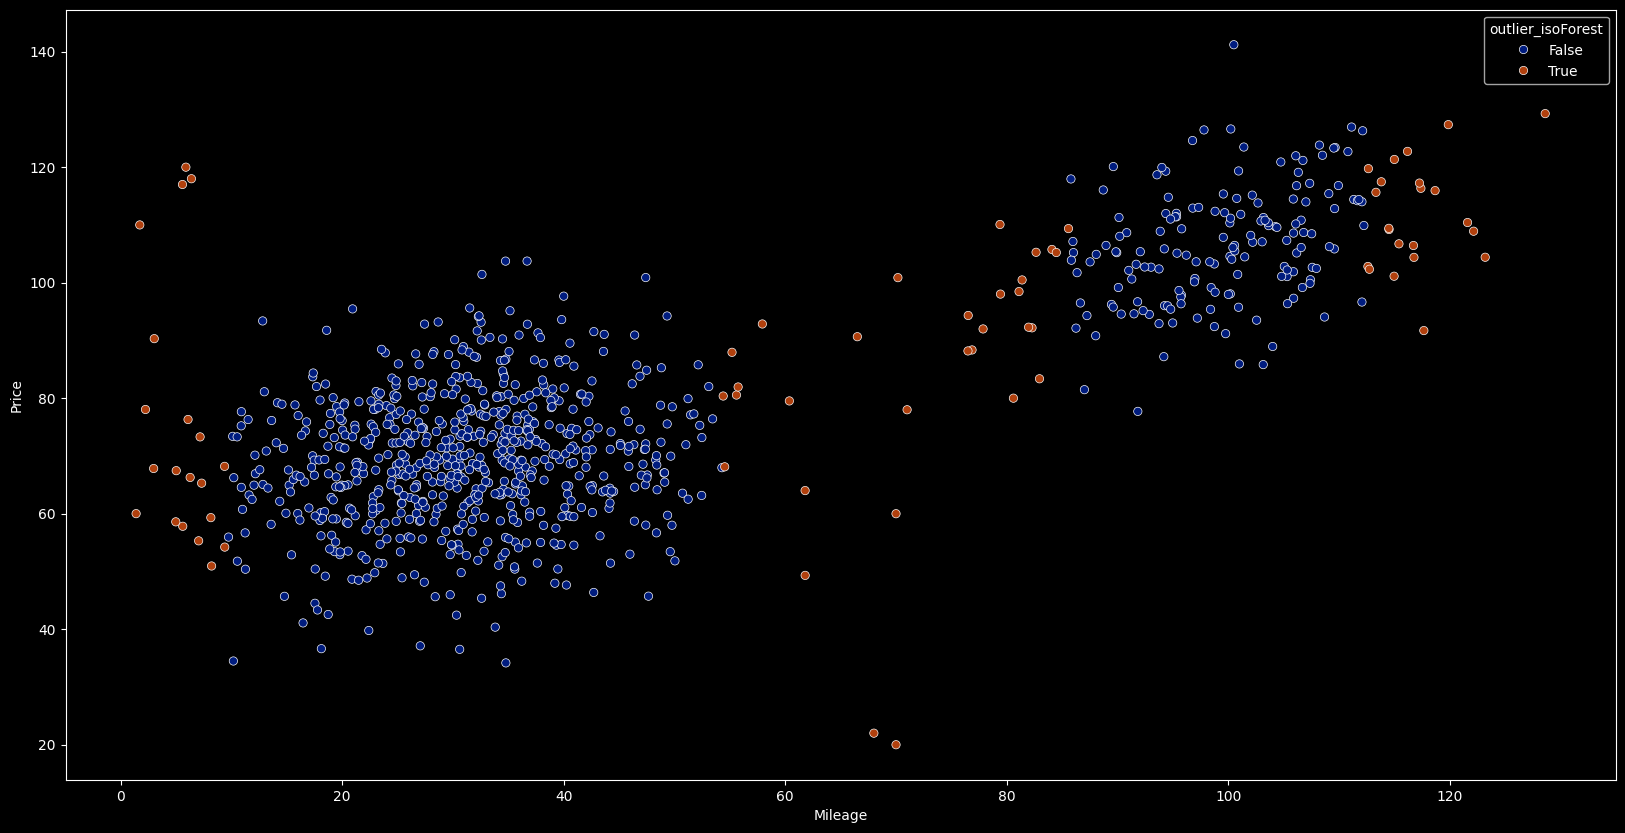

In [15]:
from sklearn.ensemble import IsolationForest

df['outlier_isoForest'] = IsolationForest(random_state= 0 , contamination = 0.08).fit_predict(x.to_numpy().reshape(-1 , 1) , y)
df['outlier_isoForest'] = df['outlier_isoForest'].apply(lambda x : False if x == 1 else True )
sns.scatterplot(df , x= 'Mileage' , y = 'Price' , hue = 'outlier_isoForest' , palette = 'dark')
plt.show()

In [16]:
df

,Mileage,Price,outlier_ee,outlier_iqr,outlier_ransac,outlier_isoForest
0,54.282388,67.967708,False,False,False,False
1,17.331911,70.023637,False,False,False,False
2,36.548113,68.080455,False,False,False,False
3,42.567541,71.058755,False,False,False,False
4,5.608853,57.822432,False,True,False,True
...,...,...,...,...,...,...
903,5.584939,117.000000,False,True,True,True
904,70.000000,20.000000,False,False,True,True
905,68.000000,22.000000,False,False,True,True
906,70.000000,60.000000,False,False,True,True


# Local Outlier Factor:


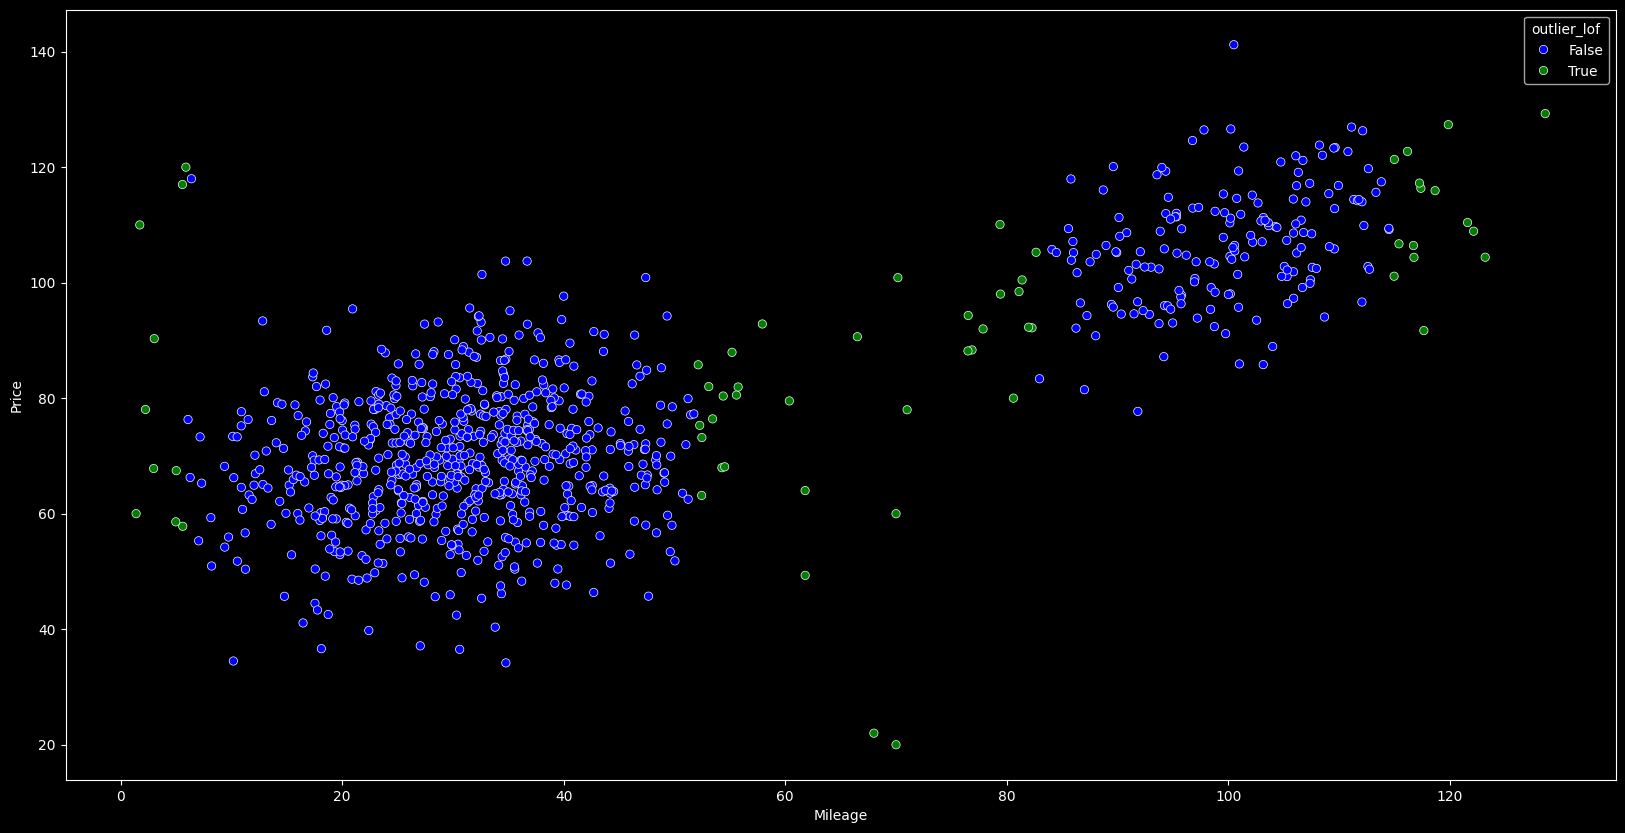

In [17]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors= 40 , contamination= 0.065)
df['outlier_lof'] = lof.fit_predict(x.to_numpy().reshape(-1 , 1) , y)
df['outlier_lof'] = df['outlier_lof'].apply(lambda x : True if x == -1 else False)
sns.scatterplot(df , x = 'Mileage' , y = 'Price' , hue = 'outlier_lof')
plt.show()

In [20]:
df.head()

,Mileage,Price,outlier_ee,outlier_iqr,outlier_ransac,outlier_isoForest,outlier_lof
0,54.282388,67.967708,False,False,False,False,True
1,17.331911,70.023637,False,False,False,False,False
2,36.548113,68.080455,False,False,False,False,False
3,42.567541,71.058755,False,False,False,False,False
4,5.608853,57.822432,False,True,False,True,True


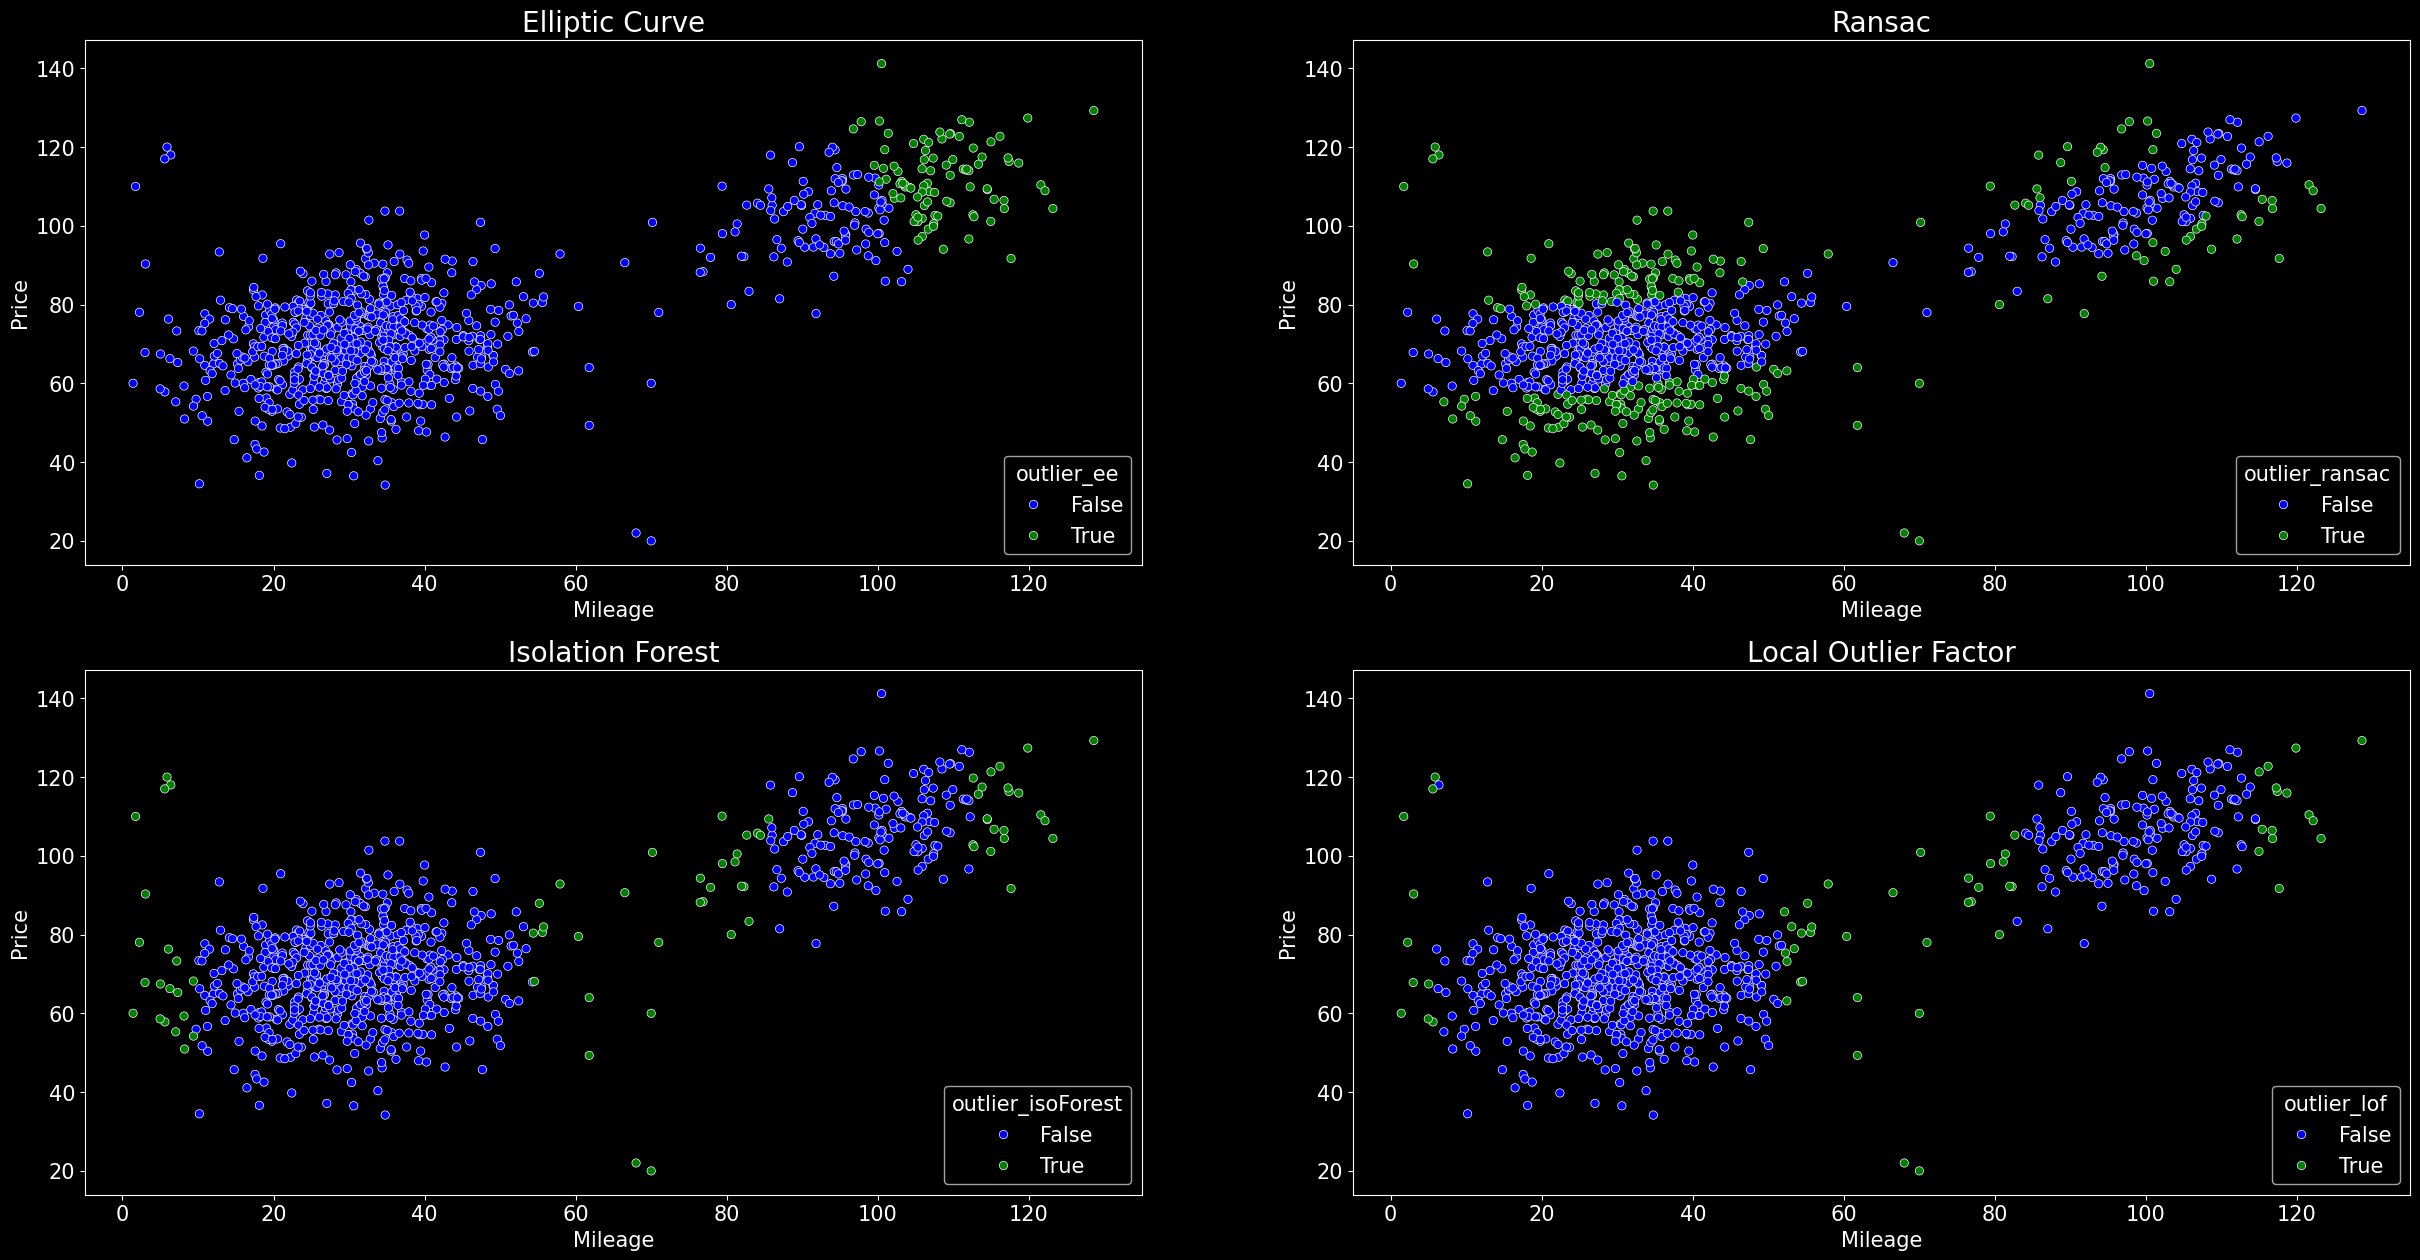

In [35]:
#final:
plt.figure(figsize=(30 , 15))

plt.subplot(2 , 2, 1)
sns.scatterplot(df , x = 'Mileage' , y = 'Price' , hue = 'outlier_ee')
plt.title('Elliptic Curve' , fontsize = 20)

plt.subplot(2 , 2, 2)
sns.scatterplot(df , x = 'Mileage' , y = 'Price' , hue = 'outlier_ransac')
plt.title('Ransac' , fontsize = 20)


plt.subplot(2 ,2 , 3)
sns.scatterplot(df , x = 'Mileage' , y = 'Price' , hue = 'outlier_isoForest')
plt.title('Isolation Forest' , fontsize = 20)


plt.subplot(2 ,2 , 4)
sns.scatterplot(df , x = 'Mileage' , y = 'Price' , hue = 'outlier_lof')
plt.title('Local Outlier Factor' , fontsize = 20)
plt.show()